<a href="https://colab.research.google.com/github/yonghwadragon/Handwritten-ML-Project/blob/main/MNIST_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 25년 3월 9일에 개선한 코드

In [1]:
########################
# MNIST_4.ipynb
########################

# ---
# 1) 필수 라이브러리 import
# ---
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

######################
# Helper functions
######################

def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    return (x > 0).astype(float)

def softmax(u):
    # 오버플로 방지
    shift_u = u - np.max(u)
    exp_u = np.exp(shift_u)
    return exp_u / np.sum(exp_u)

def cross_entropy(y, t):
    # y, t shape = (10,)
    return -np.sum(t * np.log(y + 1e-12))

######################
# Step A. MNIST 데이터 로드
######################
# TensorFlow Keras MNIST
from tensorflow.keras.datasets import mnist

(X_train, T_train), (X_test, T_test) = mnist.load_data()
# shape: (60000, 28, 28), (60000,), (10000, 28, 28), (10000,)

# Flatten & normalize
X_train_flatten = X_train.reshape(X_train.shape[0], -1) / 255.0  # (60000, 784)
X_test_flatten  = X_test.reshape(X_test.shape[0], -1)  / 255.0   # (10000, 784)

######################
# Step B. MNIST 데이터를 .bin 파일로 저장
######################
with open('trainimages.bin', 'wb') as f_img:
    pickle.dump(X_train_flatten, f_img)

with open('trainlabels.bin', 'wb') as f_lbl:
    pickle.dump(T_train, f_lbl)

with open('testimages.bin', 'wb') as f_img:
    pickle.dump(X_test_flatten, f_img)

with open('testlabels.bin', 'wb') as f_lbl:
    pickle.dump(T_test, f_lbl)

print("✅ trainimages.bin / testimages.bin 생성 완료")

######################
# Step C. 수동 MLP 구현 함수
######################
def train_custom_mlp(X, T, hidden_node=100, eta=0.001, max_iter=50):
    """
    ReLU + Softmax + Cross Entropy
    은닉층: hidden_node, 출력층: 10
    X shape: (N,784)
    T shape: (N,)
    """
    input_node = 784
    output_node = 10

    np.random.seed(10)
    # 가중치 초기화
    w = 0.1 * (2*np.random.random((hidden_node, input_node+1)) - 1)  # (hidden_node, 785)
    v = 0.1 * (2*np.random.random((output_node, hidden_node+1)) - 1) # (10, hidden_node+1)

    xl = np.ones((input_node+1,1))     # 입력 + bias
    z  = np.ones((hidden_node+1,1))    # 은닉 + bias

    N = len(X)
    for epoch in range(max_iter):
        E = 0.0
        for i in range(N):
            # Forward
            xl[1:,0] = X[i]
            uh = np.dot(w, xl)               # (hidden_node,1)
            z[1:, 0] = relu(uh).reshape(-1)               # ReLU

            uo = np.dot(v, z)               # (10,1)
            y  = softmax(uo.flatten())      # Softmax -> shape(10,)

            # Cross Entropy
            t = np.zeros(output_node)
            t[T[i]] = 1.0
            E += cross_entropy(y, t)

            # Backprop
            del_k = (y - t).reshape(-1,1)    # (10,1)
            dEdv = np.dot(del_k, z.T)        # (10, hidden_node+1)

            del_j = d_relu(uh).reshape(-1,1) * np.dot(v[:,1:].T, del_k)  # (hidden_node,1)
            dEdw = np.dot(del_j, xl.T)       # (hidden_node, 785)

            # Update
            v -= eta * dEdv
            w -= eta * dEdw

        E /= N
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{max_iter}, Error={E:.6f}")

    return w, v


def evaluate_custom_mlp(X, T, w, v):
    """
    입력: X(N,784), T(N,), w, v
    출력: accuracy
    """
    correct = 0
    N = len(X)
    input_node = 784
    hidden_node = w.shape[0]

    xl = np.ones((input_node+1,1))
    z  = np.ones((hidden_node+1,1))

    for i in range(N):
        xl[1:,0] = X[i]
        uh = np.dot(w, xl)
        z[1:,0] = relu(uh).reshape(-1)
        uo = np.dot(v, z)
        y  = softmax(uo.flatten())

        predict = np.argmax(y)
        if predict == T[i]:
            correct += 1

    acc = 100.0 * correct / N
    return acc


######################
# Step D. Random Search 구현 (간단)
######################
def random_search_hyperparams(X_train, T_train, X_val, T_val):
    # search space
    hidden_candidates = [30, 50, 100]
    eta_candidates = [0.01, 0.001]
    max_iter_candidates = [20, 50, 100]

    best_acc = -1.0
    best_params = None
    best_w, best_v = None, None

    for hidden_node in hidden_candidates:
        for eta in eta_candidates:
            for max_iter in max_iter_candidates:
                print(f"Try: hidden={hidden_node}, eta={eta}, max_iter={max_iter}")
                # 학습
                w_temp, v_temp = train_custom_mlp(X_train, T_train,
                                                  hidden_node=hidden_node,
                                                  eta=eta,
                                                  max_iter=max_iter)
                # 평가(검증)
                acc = evaluate_custom_mlp(X_val, T_val, w_temp, v_temp)
                print(f" -> Validation Accuracy= {acc:.2f}%")

                if acc > best_acc:
                    best_acc = acc
                    best_params = (hidden_node, eta, max_iter)
                    best_w, best_v = w_temp, v_temp

    return best_params, best_w, best_v, best_acc


######################
# Step E. 실제 실행
######################
# 1) 데이터 불러오기(.bin)
with open("trainimages.bin", "rb") as f_trimg:
    X_train_loaded = pickle.load(f_trimg)  # (60000,784)
with open("trainlabels.bin", "rb") as f_trlbl:
    T_train_loaded = pickle.load(f_trlbl)

with open("testimages.bin", "rb") as f_teimg:
    X_test_loaded = pickle.load(f_teimg)   # (10000,784)
with open("testlabels.bin", "rb") as f_telbl:
    T_test_loaded = pickle.load(f_telbl)

# 2) Train/Validation split
from sklearn.model_selection import train_test_split
X_tr, X_val, T_tr, T_val = train_test_split(
    X_train_loaded, T_train_loaded, test_size=0.2, random_state=42
)

# 3) Random Search
best_params, best_w, best_v, best_acc = random_search_hyperparams(
    X_tr, T_tr,
    X_val, T_val
)
print("\n[RandomSearch Result]")
print("Best Params:", best_params)
print("Best Validation Acc:", best_acc)

# 4) 베스트 파라미터로 최종 모델 평가
final_acc = evaluate_custom_mlp(X_test_loaded, T_test_loaded, best_w, best_v)
print(f"Final Test Accuracy = {final_acc:.2f}%")

# 5) 베스트 모델 저장
import numpy as np
np.savez("custom_best_model.npz", w=best_w, v=best_v)
print("✅ Best Model Saved: custom_best_model.npz")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ trainimages.bin / testimages.bin 생성 완료
Try: hidden=30, eta=0.01, max_iter=20
Epoch 5/20, Error=0.103517
Epoch 10/20, Error=0.067311
Epoch 15/20, Error=0.055164
Epoch 20/20, Error=0.045128
 -> Validation Accuracy= 96.15%
Try: hidden=30, eta=0.01, max_iter=50
Epoch 5/50, Error=0.103517
Epoch 10/50, Error=0.067311
Epoch 15/50, Error=0.055164
Epoch 20/50, Error=0.045128
Epoch 25/50, Error=0.042571
Epoch 30/50, Error=0.037852
Epoch 35/50, Error=0.032886
Epoch 40/50, Error=0.039952
Epoch 45/50, Error=0.034150
Epoch 50/50, Error=0.035052
 -> Validation Accuracy= 95.84%
Try: hidden=30, eta=0.01, max_iter=100
Epoch 5/100, Error=0.103517
Epoch 10/100, Error=0.067311
Epoch 15/100, Error=0.055164
Epoch 20/100, Error=0.045128
Epoch 25/100, Error=0.042571
Epoch 30/100, Error=0.037852
Epoch 35/100, Error=0.032886
Epoch 40/100, Error=0.039952
Epoch 45/100, Error=0.034150
Epoch 50/100, Error=0.035052
Epoch 55/100, Error=0.032425
Epoch 60/100, Error=0

# 기존 25년 3월 9일 이전에 작성한 코드

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np
import pickle

# Load MNIST dataset
(X_train, T_train), (X_test, T_test) = mnist.load_data()

# Flatten images
X_train_flatten = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flatten = X_test.reshape(X_test.shape[0], -1) / 255.0

# Save data to binary files
with open('trainimages.bin', 'wb') as f:
    pickle.dump(X_train_flatten, f)

with open('trainlabels.bin', 'wb') as f:
    pickle.dump(T_train, f)

# Save test data to binary files
with open('testimages.bin', 'wb') as f:
    pickle.dump(X_test_flatten, f)
with open('testlabels.bin', 'wb') as f:
    pickle.dump(T_test, f)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load MNIST dataset
(X_train, T_train), (_, _) = mnist.load_data()
X_train_flatten = X_train.reshape(X_train.shape[0], -1) / 255.0

# Split data into train and validation sets
X_train, X_val, T_train, T_val = train_test_split(X_train_flatten, T_train, test_size=0.2, random_state=42)

# Define MLPClassifier
mlp = MLPClassifier()

In [4]:
from sklearn.model_selection import RandomizedSearchCV

# RandomizedSearchCV를 위한 하이퍼파라미터 분포 정의
param_dist = {
    'hidden_layer_sizes': [(30,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate_init': [0.01, 0.001],
    'max_iter': [20, 50, 100]
}

# RandomizedSearchCV 생성
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, random_state=42)

# 랜덤 탐색 수행
random_search.fit(X_train, T_train)

# 최적의 파라미터와 해당하는 정확도 출력
print("최적의 파라미터: ", random_search.best_params_)
print("검증 세트에서 최고 정확도: ", random_search.best_score_)

# 최적의 모델을 사용하여 테스트 세트에서 성능 평가
best_model_random = random_search.best_estimator_
T_pred_random = best_model_random.predict(X_val)
accuracy_random = accuracy_score(T_val, T_pred_random)
print("랜덤 서치에서 최적 모델을 사용한 검증 세트 정확도: ", accuracy_random)

최적의 파라미터:  {'max_iter': 100, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'activation': 'relu'}
검증 세트에서 최고 정확도:  0.9710208333333332
랜덤 서치에서 최적 모델을 사용한 검증 세트 정확도:  0.9768333333333333


In [5]:
# 실험 결과 저장
with open("results.txt", "w") as f:
    f.write(f"최적의 파라미터: {random_search.best_params_}\n")
    f.write(f"검증 세트에서 최고 정확도: {random_search.best_score_}\n")
    f.write(f"랜덤 서치에서 최적 모델을 사용한 검증 세트 정확도: {accuracy_random}\n")

In [6]:
# 최적 모델 저장
import joblib # pickle보다 joblib이 모델 저장에 더 적합

joblib.dump(best_model_random, "best_model.pkl")

['best_model.pkl']

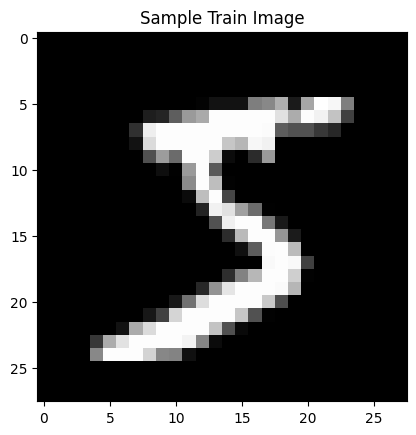

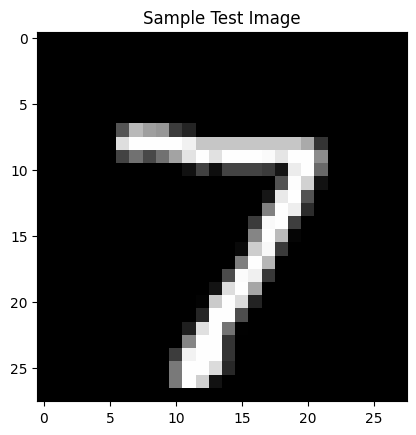

In [10]:
import matplotlib.pyplot as plt
import pickle

# Train 데이터 확인
with open("trainimages.bin", "rb") as f:
    X_train = pickle.load(f)
plt.imshow(X_train[0].reshape(28, 28), cmap="gray")
plt.title("Sample Train Image")
plt.show()

# Test 데이터 확인
with open("testimages.bin", "rb") as f:
    X_test = pickle.load(f)
plt.imshow(X_test[0].reshape(28, 28), cmap="gray")
plt.title("Sample Test Image")
plt.show()
